## Info

When the COVID-19 crisis first entered the U.S. and even up through the first spike in cases, I was too anxious to really post anything related to it. Now that we're clearly going into the "second peak" phase, might as well add to the projects.

### The Work

We will take a look at the cases and deaths as reported through Johns Hopkis data and produce simple plots for the US in both of those instances. Then we will examine only NEW cases from a statistical and forecasting point. Finally we will try out this **STUMPY** package and examine the matrix profile of the new cases.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sma
from scipy import stats
import stumpy
import pmdarima as pmd

from tqdm import tqdm_notebook
from collections import Counter
import seaborn as sns

import datetime as dt
import gc
import os
import warnings

%matplotlib inline

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### Current Cases

In [2]:
url = '''https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'''

dfc = pd.read_csv(url)

In [3]:
print(dfc.shape)
dfc.head()

(266, 172)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,...,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,...,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102,24766,25527,26310,26874,27532,27878,28424,28833,29157,29481,29640,30175,30451,30616,30967,31238,31517,31836,32022,32324,32672,32951,33190,33384
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,949,964,969,981,989,998,1004,1029,1050,1076,1099,1122,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299,1341,1385,1416,1464,1521,1590,1672,1722,1788,1838,1891,1962,1995,2047,2114,2192,2269,2330,2402,2466,2535,2580,2662,2752,2819,2893,2964,3038
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,...,7377,7542,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382,10484,10589,10698,10810,10919,11031,11147,11268,11385,11504,11631,11771,11920,12076,12248,12445,12685,12968,13273,13571,13907,14272,14657,15070,15500,15941,16404,16879
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,761,762,762,762,762,762,763,763,763,763,764,764,764,765,844,851,852,852,852,852,852,852,852,852,853,853,853,853,854,854,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52,52,58,60,61,69,70,70,71,74,81,84,86,86,86,86,86,86,88,91,92,96,113,118,130,138,140,142,148,155,166,172,176,183,186,189,197,212,212,259,267,276,284,291,315,328,346,346,346,386


In [4]:
# dfc[dfc['Country/Region'].str.contains("US")]
usc = dfc[dfc['Country/Region'].str.contains("US")].drop(['Province/State','Country/Region','Lat','Long'],
                                                         axis=1).T
usc = pd.DataFrame(usc)
usc.columns = ['us_cases']
print(usc.shape)
usc.index = pd.to_datetime(usc.index)
usc.head()

(168, 1)


,us_cases
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5


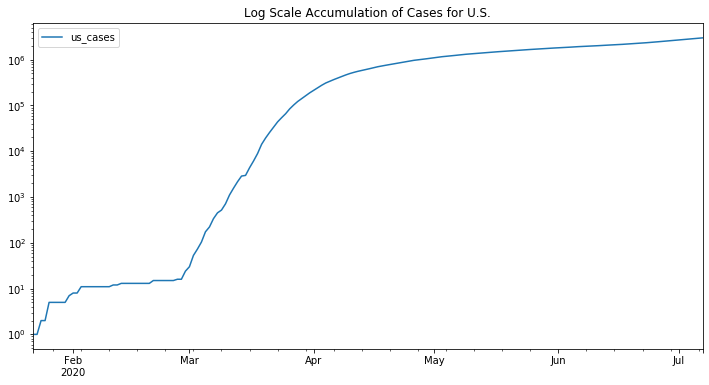

In [5]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
usc.plot(ax=ax);
ax.set_title("Log Scale Accumulation of Cases for U.S.");
ax.set_yscale("log");

### Current Deaths

In [6]:
url = '''https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'''

dfd = pd.read_csv(url)

In [7]:
print(dfd.shape)
dfd.head()

(266, 172)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,...,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,178,187,193,205,216,218,219,220,227,235,246,249,257,265,270,294,300,309,327,357,369,384,405,426,446,451,471,478,491,504,546,548,569,581,598,618,639,675,683,703,721,733,746,774,807,819,826,864,898,920
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,31,31,31,31,31,32,32,33,33,33,33,33,33,33,33,33,33,33,34,34,34,34,34,35,36,36,36,36,37,38,39,42,43,44,44,45,47,49,51,53,55,58,62,65,69,72,74,76,79,81
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,561,568,575,582,592,600,609,617,623,630,638,646,653,661,667,673,681,690,698,707,715,724,732,741,751,760,767,777,788,799,811,825,837,845,852,861,869,878,885,892,897,905,912,920,928,937,946,952,959,968
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,6,6,6,6,7,8,8,9,9,10,10,10,10,10,10,11,11,13,15,17,18,19,19,19,21


In [8]:

usd = dfd[dfd['Country/Region'].str.contains("US")].drop(['Province/State','Country/Region','Lat','Long'],
                                                         axis=1).T
usd = pd.DataFrame(usd)
usd.columns = ['us_deaths']
print(usd.shape)
usd.index = pd.to_datetime(usd.index)
usd.head()

(168, 1)


,us_deaths
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0


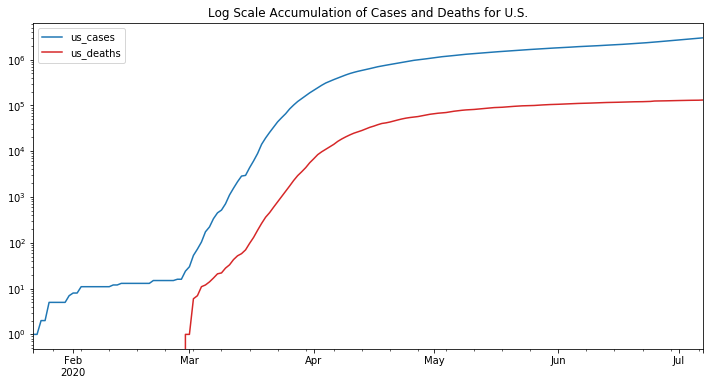

In [9]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
usc.plot(ax=ax);
usd.plot(ax=ax, style='C3-');
ax.set_title("Log Scale Accumulation of Cases and Deaths for U.S.");
ax.set_yscale("log");

**There is not much to write home about these to plots. I suppose you could say one is keeping pace with the other which is not good.**

### New Cases

We can define the new cases but taking the first difference of the cases. A simple check can show us that we have it right.

In [10]:
usc['new_cases'] = usc.us_cases.diff()
usc.head(10)

,us_cases,new_cases
2020-01-22,1,NaN
2020-01-23,1,0.0
2020-01-24,2,1.0
2020-01-25,2,0.0
2020-01-26,5,3.0
2020-01-27,5,0.0
2020-01-28,5,0.0
2020-01-29,5,0.0
2020-01-30,5,0.0
2020-01-31,7,2.0


Yes, the first difference appears to work for defining new cases.

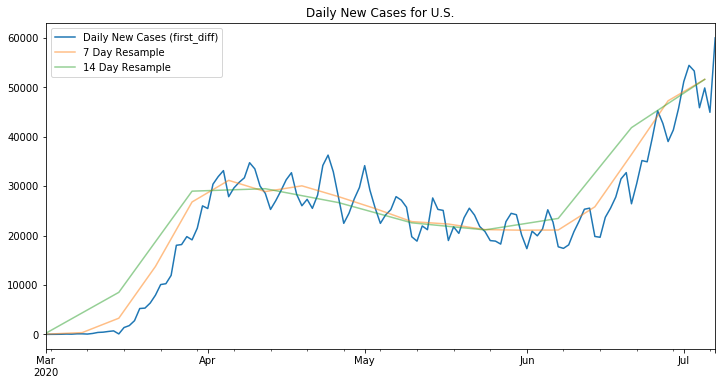

In [12]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
usc.new_cases.loc['2020-03-01':].plot(ax=ax);
usc.new_cases.loc['2020-03-01':].resample('7D').mean().plot(ax=ax, alpha=0.5);
usc.new_cases.loc['2020-03-01':].resample('14D').mean().plot(ax=ax, alpha=0.5);
ax.set_title("Daily New Cases for U.S.");
plt.legend(['Daily New Cases (first_diff)','7 Day Resample','14 Day Resample']);

Using the first difference we manage to get the daily new case counts, and I added the 7 and 14 day resampled means since there is underlying structure with the way the counts are recorded and the apparent incubation period.

I also started the plot from March 1st since that is when things really started picking up according to the data collection.

### Forecasting the New Cases

In [13]:
y = usc.us_cases.loc['2020-03-01':].diff().dropna()

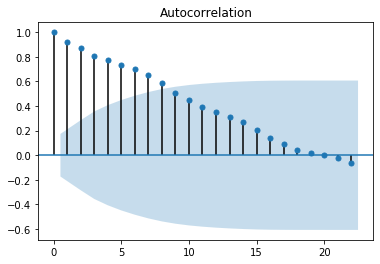

In [14]:
# pmd.plot_acf(y);
sma.tsa.graphics.plot_acf(y);

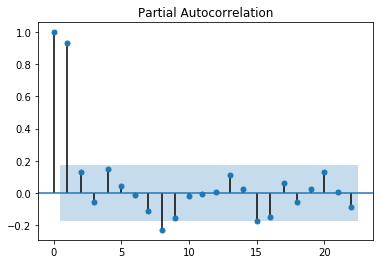

In [15]:
# pmd.plot_pacf(y);
sma.tsa.graphics.plot_pacf(y);

It appears there is serial correlation at 1,7,8, and 9 lags at least.

In [53]:

arima = pmd.auto_arima(y=y, max_p=21, max_d=1, max_q=21, seasonal = True, m=7, out_of_sample_size=7)
print(arima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  128
Model:             SARIMAX(3, 1, 2)x(0, 0, [1], 7)   Log Likelihood               -1170.888
Date:                             Wed, 08 Jul 2020   AIC                           2357.775
Time:                                     10:00:23   BIC                           2380.529
Sample:                                          0   HQIC                          2367.020
                                             - 128                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    536.7290    249.594      2.150      0.032      47.534    1025.924
ar.L1          0.8964      

**The model comes out with differnce on our already differenced data. As well as AutoRegressive terms  on lags 1 and 2 lags and moving averages across 1 and 2 lags.** 

The variables are all significant but the large sigma term suggests we are missing a lot of variance.


We also set 7 days for an out of sample test to confirm the best model.

In [54]:
mod = sma.tsa.SARIMAX(endog=y, order=(3,1,2), seasonal_order=(0,0,1,7), trend='c')
fit = mod.fit()
print(fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            us_cases   No. Observations:                  128
Model:             SARIMAX(3, 1, 2)x(0, 0, [1], 7)   Log Likelihood               -1174.577
Date:                             Wed, 08 Jul 2020   AIC                           2365.153
Time:                                     10:00:41   BIC                           2387.907
Sample:                                 03-02-2020   HQIC                          2374.398
                                      - 07-07-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    736.7936    324.296      2.272      0.023     101.185    1372.402
ar.L1          0.7885      

We re-run the model outside of the ARIMA and we can consider this our final model which we can forecast on. All of the variables remain significant as well which is a good sign.

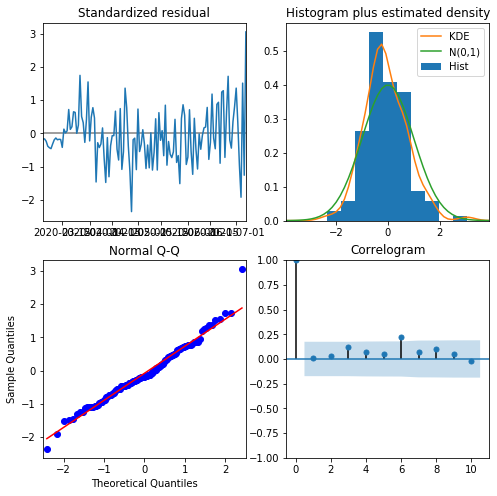

In [55]:
fit.plot_diagnostics(figsize=(8,8));

There appears there is still some serial correlation existent in the residual even at a second difference. Though the errors appear normal.

In [56]:
## Lets forecast out a month based on this data
forecast = fit.get_forecast(30)
f_mean = forecast.predicted_mean
ci = forecast.conf_int()
pred = fit.predict()

**In addition to this model above, I am working with one that has AR terms on 1,6,7 and 14.**

In [57]:
arimod_714 = sma.tsa.SARIMAX(endog=y, order=([1,0,0,0,0,1,1,0,0,0,0,0,0,1],1,0), trend='c',
                                      seasonal_order=(0,1,0,7))
fit_714 = arimod_714.fit()
print(fit_714.summary())

                                           SARIMAX Results                                           
Dep. Variable:                                      us_cases   No. Observations:                  128
Model:             SARIMAX([1, 6, 7, 14], 1, 0)x(0, 1, 0, 7)   Log Likelihood               -1107.760
Date:                                       Wed, 08 Jul 2020   AIC                           2227.519
Time:                                               10:00:50   BIC                           2244.244
Sample:                                           03-02-2020   HQIC                          2234.311
                                                - 07-07-2020                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     46.0051    2

I decided to try an AR 7 / AR 14 model as well since there seems to be a seasonality on 7 days and the 14 day window for symptoms to develop.

In [58]:
forecast_714 = fit_714.forecast(30)
pred_714 = fit_714.predict()

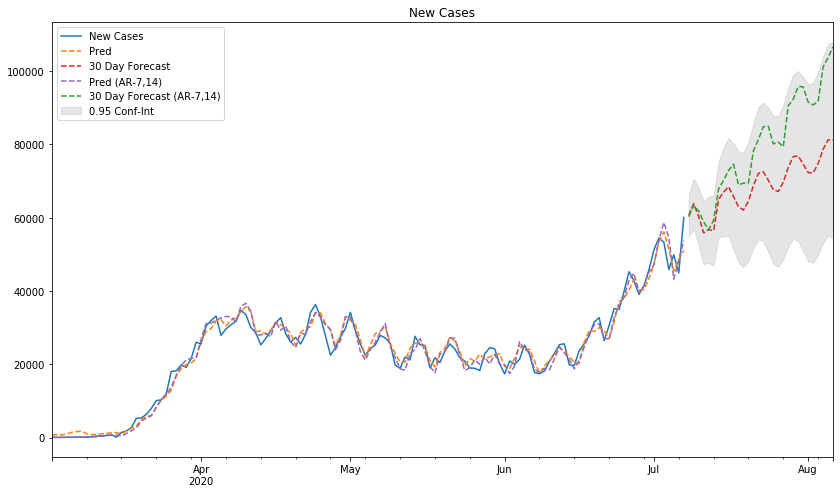

In [59]:
fig, ax=plt.subplots(1,1,figsize=(14,8))
y.plot(ax=ax);
pred.plot(ax=ax, style=['C1--']);
f_mean.plot(ax=ax, style=['C3--']);
pred_714.plot(ax=ax, style=['C4--']);
forecast_714.plot(ax=ax, style=['C2--'])
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=.2);
plt.legend(['New Cases','Pred','30 Day Forecast','Pred (AR-7,14)','30 Day Forecast (AR-7,14)',
            '0.95 Conf-Int']);
plt.title("New Cases");

- Our prediction appears to fit the actual data well.
- The forecast clearly follows within the 7 day trend of spikes and drops from the weekend, but is not nearly as varianced as what will likely occur.
- The trend of the forecast continues upward although not at the pace are actually experiencing.
- The 7/14 model has a significantly higher trend.
- A next step would be to add the confidence interval for the forecast.

**There are other methods that we can use to forecast, such as incorporating seasonality. We could also try to predict on moving averages of 7 days to attempt to smooth out the *seasonality* that is evident.**

Im going to try and add this to DATAPANE.


In [60]:
import datapane as dp
import plotly.express as px
import plotly.graph_objects as go

In [61]:
ci.head()

,lower us_cases,upper us_cases
2020-07-08,54898.642564,66389.694787
2020-07-09,57040.368331,70646.722032
2020-07-10,52304.318727,68249.195069
2020-07-11,47285.877745,64409.878468
2020-07-12,47700.370507,65812.902898


In [62]:
plot_df = pd.DataFrame(y)
plot_df['Arima_212_Pred'] = pred
# plot_df['Arima_212_Forc'] = f_mean
plot_df = pd.concat([plot_df,f_mean], axis=0)
plot_df.columns = ['Arima_212_Forc','Arima_212_Pred','US_Cases']
# plot_df['Arima_7_14_Pred'] = pred_714
# plot_df['Arima_7_14_Forc'] = forecast_714
plot_df['Arima_212_lci'] = ci['lower us_cases']
plot_df['Arima_212_uci'] = ci['upper us_cases']


In [63]:
plot_df.head()

,Arima_212_Forc,Arima_212_Pred,US_Cases,Arima_212_lci,Arima_212_uci
2020-03-02,NaN,675.739758,23.0,NaN,NaN
2020-03-03,NaN,726.758651,20.0,NaN,NaN
2020-03-04,NaN,722.991063,31.0,NaN,NaN
2020-03-05,NaN,980.297349,70.0,NaN,NaN
2020-03-06,NaN,1400.174957,48.0,NaN,NaN


In [64]:
plot_df.tail()

,Arima_212_Forc,Arima_212_Pred,US_Cases,Arima_212_lci,Arima_212_uci
2020-08-02,72178.554482,NaN,NaN,47655.325908,96701.783057
2020-08-03,74798.282408,NaN,NaN,49851.490781,99745.074036
2020-08-04,78628.037967,NaN,NaN,53129.247115,104126.828818
2020-08-05,81234.250193,NaN,NaN,55092.408039,107376.092347
2020-08-06,81166.999563,NaN,NaN,54417.780025,107916.219101


In [85]:
plot_name = 'Covid19 - New Cases and Forecast for U.S.'

fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_df.index,y=plot_df['Arima_212_uci'],showlegend=True,name='Upper CI',
                         line = dict(color='gray', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=plot_df.index,y=plot_df['Arima_212_lci'],showlegend=True,name='Lower CI',
                         line = dict(color='gray', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=plot_df.index,y=plot_df['US_Cases'],showlegend=True,name='New Cases',
                         line = dict(color='royalblue', width=2)))
fig.add_trace(go.Scatter(x=plot_df.index,y=plot_df['Arima_212_Pred'],showlegend=True,name='Prediction',
                         line = dict(color='red', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=plot_df.index,y=plot_df['Arima_212_Forc'],showlegend=True,name='Forecast',
                         line = dict(color='green', width=2)))
fig.update_layout(title='SARIMA (3,1,2)x(0,0,1,7) on Covid19 New Cases for U.S.',
                   xaxis_title='Day',
                   yaxis_title='Count of New Cases')

fig.show()

In [86]:
r = dp.Report(dp.Plot(fig))
r.save(path='covid_plot.html', open=True)

In [87]:
r.publish(name='covid19_us_new_cases_forecast')

### New Deaths

In [37]:
yd = usd.us_deaths.loc['2020-03-01':].diff().dropna()

## we will start deaths 14 days later than cases (or not)

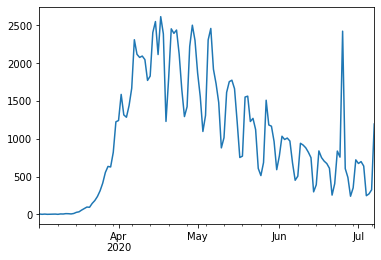

In [38]:
yd.plot()

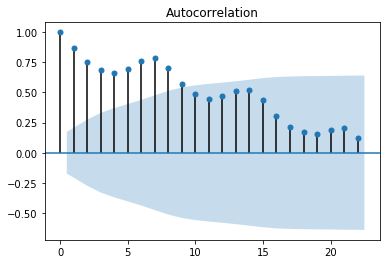

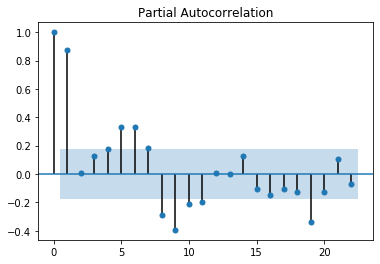

In [39]:
sma.tsa.graphics.plot_acf(yd);
sma.tsa.graphics.plot_pacf(yd);

The deaths have similar correlation to the cases.

In [41]:
## were making a few adjustments here
arimad = pmd.auto_arima(y=yd, max_p=24, max_d=1, max_q=24, seasonal = True, m=14, out_of_sample_size=7)
print(arimad.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  128
Model:             SARIMAX(4, 1, 2)x(0, 0, [1], 14)   Log Likelihood                -897.919
Date:                              Wed, 08 Jul 2020   AIC                           1813.839
Time:                                      09:58:00   BIC                           1839.436
Sample:                                           0   HQIC                          1824.239
                                              - 128                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.0818     24.195      0.169      0.866     -43.340      51.503
ar.L1          0.68

There are alot of similarities between deaths and cases which isnt surprising I guess. 

                                      SARIMAX Results                                       
Dep. Variable:                            us_deaths   No. Observations:                  128
Model:             SARIMAX(4, 1, 2)x(0, 0, [1], 14)   Log Likelihood                -897.937
Date:                              Wed, 08 Jul 2020   AIC                           1813.873
Time:                                      09:58:33   BIC                           1839.471
Sample:                                  03-02-2020   HQIC                          1824.273
                                       - 07-07-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.2316     24.464      0.296      0.768     -40.716      55.179
ar.L1          0.70

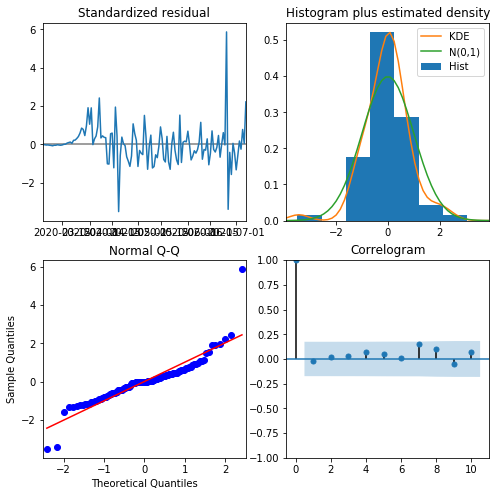

In [42]:
modd = sma.tsa.SARIMAX(endog=yd, order=(4,1,2), seasonal_order=(0,0,1,14), trend='c')
fitd = modd.fit()
print(fitd.summary())
fitd.plot_diagnostics(figsize=(8,8));

Our final model for deaths is not as useful. We lose a lot of traction in the variables and its likely because we miss the jump in deaths in June.

In [43]:
## Lets forecast out a month based on this data
forecastd = fitd.forecast(30)
predd = fitd.predict()

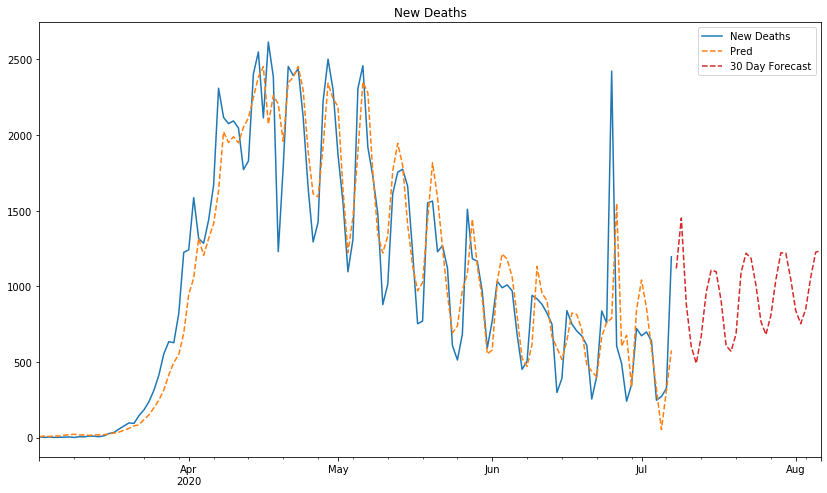

In [44]:
fig, ax=plt.subplots(1,1,figsize=(14,8))
yd.plot(ax=ax);
predd.plot(ax=ax, style=['C1--']);
forecastd.plot(ax=ax, style=['C3--']);
plt.legend(['New Deaths','Pred','30 Day Forecast']);
plt.title("New Deaths");

Because the model misses the jump in June, we are hard pressed to get a very good forecast.

### STUMPY

- https://github.com/TDAmeritrade/stumpy

I stumbled on this through the internet but essentially it is another tool at our disposal for examining time series. The basic idea is that you take your time series, select a window of points which slides across the data set one point at a time. At the same time, another window of the same size slides across and calculates the *Euclidean Distance* (magnitude) of that steady window and the second sliding window. It creates a matrix of values that are useful to us called the *matrix profile*.

In this matrix profile, the minima can tell us about motifs (repeating patters) and the maxima can tell us about outliers.

In [45]:
window = 7
mp = stumpy.stump(y, m=window)

In [46]:
mp.shape

(122, 4)

In [47]:
mp_df = pd.DataFrame(mp, columns=['matrix_profile','profile_indices','left_idx','right_idx'],
                     index = y.index[:len(mp)])
mp_df = pd.concat([y, mp_df], axis=1)

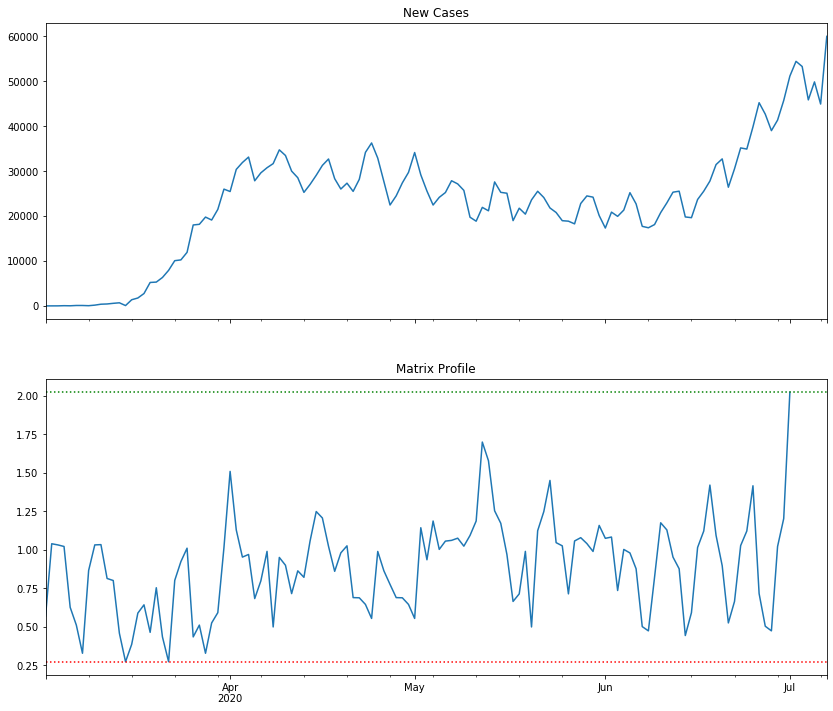

In [48]:
fig, ax=plt.subplots(2,1,figsize=(14,12), sharex=True)
mp_df.us_cases.plot(ax=ax[0]);
mp_df.matrix_profile.plot(ax=ax[1]);
ax[1].axhline(mp_df.matrix_profile.min(), color='r', ls=':');
ax[1].axhline(mp_df.matrix_profile.max(), color='g', ls=':');
ax[0].set_title("New Cases");
ax[1].set_title("Matrix Profile");

In [49]:
print(mp_df.matrix_profile.min())
print(mp_df.matrix_profile.max())

0.27292697674159183
2.024182267601069


Our minimum appears to hit two points and they also appear to be 7 days apart which is interesting considering we have the type of seasonality. The motif there only happens twice however so there may not be significant repeating patters, which we mostly already know.


Our maximums tell us another story though. Specifically that middle max in the middle of May. This could likely have been the first instance of states "opening" back up. This should have been our first hint at how things were likely going to go.

In [50]:
mp_df[mp_df.matrix_profile < 0.28]

,us_cases,matrix_profile,profile_indices,left_idx,right_idx
2020-03-15,98.0,0.272927,20,5,20
2020-03-22,7936.0,0.272927,13,13,25


In [51]:
mp_df[mp_df.matrix_profile > 1.6]

,us_cases,matrix_profile,profile_indices,left_idx,right_idx
2020-05-12,21954.0,1.70004,64,64,77
2020-07-01,51174.0,2.02418,81,81,-1


The maximum points and closest neighbors are not evenly spaced though.

There may be more insight we can glean from the matrix profile, visually I see points at the end of APril that appear to have somme sort of motif within them. For now we are going to leave it at this.